### Imports

In [67]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from tqdm import tqdm

from models.unet import UNet
from models.unet import dice_loss, dice_coeff, multiclass_dice_coeff

print('imported')

imported


### Constants

In [68]:
np.random.seed(42)
_ = torch.random.manual_seed(42)

DATA_DIR = './data/'
WEIGHT_DIR = './weights/'
STATS_DIR = './stats/'

# working device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Selected device: {}'.format(device))
print('Device name: {}'.format(torch.cuda.get_device_name(device)))

# other cosntants
# you can modify from here: and only modify whats possible to modify (for backbones and optimizers)
BATCH_SIZE = 32
EPOCHS = 100
IMG_SIZE = (128, 128)
LEARNING_RATE = 0.0001
IN_CHANNELS = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Selected device: cuda
Device name: NVIDIA RTX A6000


### Loading data

In [78]:
real_data = np.load(os.path.join(DATA_DIR, 'seg_train_data.npy'))
# fake_data = np.load(os.path.join(DATA_DIR, 'generated_HVAE_128_128_ds - brats, mask - True, dt - 0.1.npy'))
fake_data = np.load(os.path.join(DATA_DIR, 'generated_VAE_128_128_ds=brats, mask=True.npy'))

# splitting the test data
train_size = int(len(real_data) * 0.8)
test_images = real_data[train_size:, 0]
test_masks = real_data[train_size:, 1]

# combining fake and real training data
n_real, n_fake = 50, 950
train_images = np.concatenate((real_data[:n_real, 0], fake_data[:n_fake, 0]))
train_masks = np.concatenate((real_data[:n_real, 1], fake_data[:n_fake, 1]))

# shuffling the data
rand_idx = np.arange(train_images.__len__())
np.random.shuffle(rand_idx)
train_images = train_images[rand_idx]
train_masks = train_masks[rand_idx]

# converting to torch tensors
train_images = torch.tensor(train_images, dtype=torch.float32)
train_masks = torch.tensor(train_masks, dtype=torch.float32)
test_images = torch.tensor(test_images, dtype=torch.float32)
test_masks = torch.tensor(test_masks, dtype=torch.float32)

# unsqueeze the masks & images
train_images = train_images.unsqueeze(1)
train_masks = train_masks.unsqueeze(1).round()
test_images = test_images.unsqueeze(1)
test_masks = test_masks.unsqueeze(1)

print('train_images.shape: {}'.format(train_images.shape))
print('train_masks.shape: {}'.format(train_masks.shape))
print('test_images.shape: {}'.format(test_images.shape))
print('test_masks.shape: {}'.format(test_masks.shape))

train_images.shape: torch.Size([1000, 1, 128, 128])
train_masks.shape: torch.Size([1000, 1, 128, 128])
test_images.shape: torch.Size([100, 1, 128, 128])
test_masks.shape: torch.Size([100, 1, 128, 128])


Sample images:


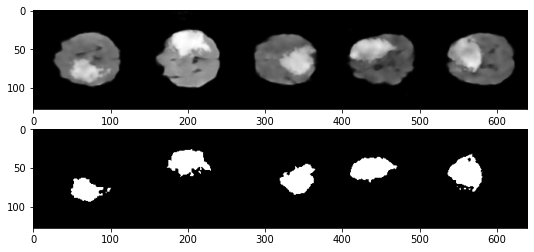

In [82]:
import matplotlib.pyplot as plt

n_sample = 5
rand_idx = np.random.randint(0, train_images.shape[0], n_sample)
print('Sample images:')
plt.figure(figsize=(20, 4))
plt.subplot(2, 1, 1)
plt.imshow(torch.hstack([img for img in train_images[rand_idx, 0]]), cmap='gray')
plt.subplot(2, 1, 2)
plt.imshow(torch.hstack([img for img in train_masks[rand_idx, 0]]), cmap='gray')
plt.show()


Sample images:


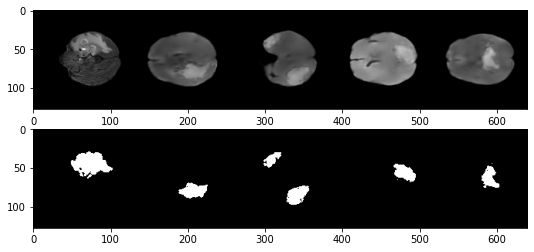

In [72]:
import matplotlib.pyplot as plt

n_sample = 5
rand_idx = np.random.randint(0, train_images.shape[0], n_sample)
print('Sample images:')
plt.figure(figsize=(20, 4))
plt.subplot(2, 1, 1)
plt.imshow(torch.hstack([img for img in train_images[rand_idx, 0]]), cmap='gray')
plt.subplot(2, 1, 2)
plt.imshow(torch.hstack([img for img in train_masks[rand_idx, 0]]), cmap='gray')
plt.show()


### Training loop and utils

In [73]:
def train_model(
        model,
        dataloader,
        n_classes = 1,
        epochs: int = 5,
        learning_rate: float = 1e-5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 2.0,
        verbose = True
):

    optimizer = torch.optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1.0, 0.01, epochs)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    
    train_loss = []
    for epoch in range(epochs):
        model.train()

        running_total_loss = 0.0

        progress = None
        if verbose: progress = tqdm(dataloader, position=0, leave=True)
        for i, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.long)

            with torch.autocast(device.type, enabled=amp):
                masks_pred = model(images)
                if n_classes == 1:
                    loss = criterion(masks_pred.squeeze(1), masks.squeeze(1).float())
                    loss += dice_loss(torch.sigmoid(masks_pred.squeeze(1)), masks.squeeze(1).float(), multiclass=False)
                else:
                    loss = criterion(masks_pred, masks)
                    loss += dice_loss(
                        F.softmax(masks_pred, dim=1).float(),
                        F.one_hot(masks, n_classes).permute(0, 3, 1, 2).float(),
                        multiclass=True
                    )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()
                # scheduler.step()

            running_total_loss += loss.item()

            if verbose:
                with torch.no_grad():
                    progress.update(1)
                    progress.set_description('Epoch: {:5}/{} - Actual loss: {:.4f}'.format(
                        epoch + 1, EPOCHS, running_total_loss / (i + 1)
                    ))

        train_loss.append(running_total_loss / len(dataloader))

        if verbose: progress.close()
        del progress

    import gc
    gc.collect()
    torch.cuda.empty_cache()

    return model, train_loss

def evaluate_model(model, test_loader, n_classes, verbose=True, **kwargs): 
    if verbose:
        print('--------------------------------------------')
        print('Test metrics (on test set)')

    model.eval()

    # criterion
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    fn = dice_coeff if n_classes == 1 else multiclass_dice_coeff

    running_dice_score, running_ce_loss = 0.0, 0.0
    predicted_masks = []
    
    # computing predictions
    for i, (images, masks) in enumerate(tqdm(test_loader, position=0, leave=True)):
        images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.long)
        masks_pred = model(images)
        if n_classes == 1:
            running_ce_loss += criterion(masks_pred.squeeze(1), masks.squeeze(1).float())
            running_dice_score += fn(torch.sigmoid(masks_pred.squeeze(1)), masks.squeeze(1).float(), reduce_batch_first=True)
        else:
            running_ce_loss += criterion(masks_pred, masks)
            running_dice_score += fn(
                F.softmax(masks_pred, dim=1).float(),
                F.one_hot(masks, n_classes).permute(0, 3, 1, 2).float(),
                multiclass=True
            )
        predicted_masks.append(masks_pred.detach().cpu())

    # computing main metrics
    dice_coefficient = running_dice_score / len(test_loader)
    ce_loss = running_ce_loss / len(test_loader)

    # adding scores to the history
    stats = {}
    stats['dice_coeff'] = dice_coefficient
    stats['ce_loss'] = ce_loss
    stats['dice_loss'] = 1 - dice_coefficient

    log = """
    --------------------------------------------
    Total loss (Dice loss + CE loss): {:.3f} ↓
    Dice loss: {:.3f} ↓
    CE loss: {:.3f} ↓
    Dice coefficient: {:.3f} ↑
    --------------------------------------------
    """.format(
        1 - dice_coefficient + ce_loss, 1 - dice_coefficient, ce_loss, dice_coefficient
    )

    if verbose: print(log)

    return stats, predicted_masks


## Model + training

In [76]:
class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

train_loader = torch.utils.data.DataLoader(IdentityDataset(train_images, train_masks), batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(IdentityDataset(test_images, test_masks), batch_size=1, shuffle=False)

model = UNet(n_channels=IN_CHANNELS, n_classes=1).to(device)

model, train_loss_history = train_model(
    model, train_loader, n_classes=1, epochs=EPOCHS, learning_rate=LEARNING_RATE, amp=False
)


Epoch:   100/100 - Actual loss: 0.1170: 100%|██████████| 31/31 [00:03<00:00,  8.52it/s]


### Evaluation

In [77]:
stats, _ = evaluate_model(model, test_loader, n_classes=1, verbose=True)

--------------------------------------------
Test metrics (on test set)


100%|██████████| 100/100 [00:01<00:00, 95.77it/s]


    --------------------------------------------
    Total loss (Dice loss + CE loss): 0.274 ↓
    Dice loss: 0.188 ↓
    CE loss: 0.085 ↓
    Dice coefficient: 0.812 ↑
    --------------------------------------------
    


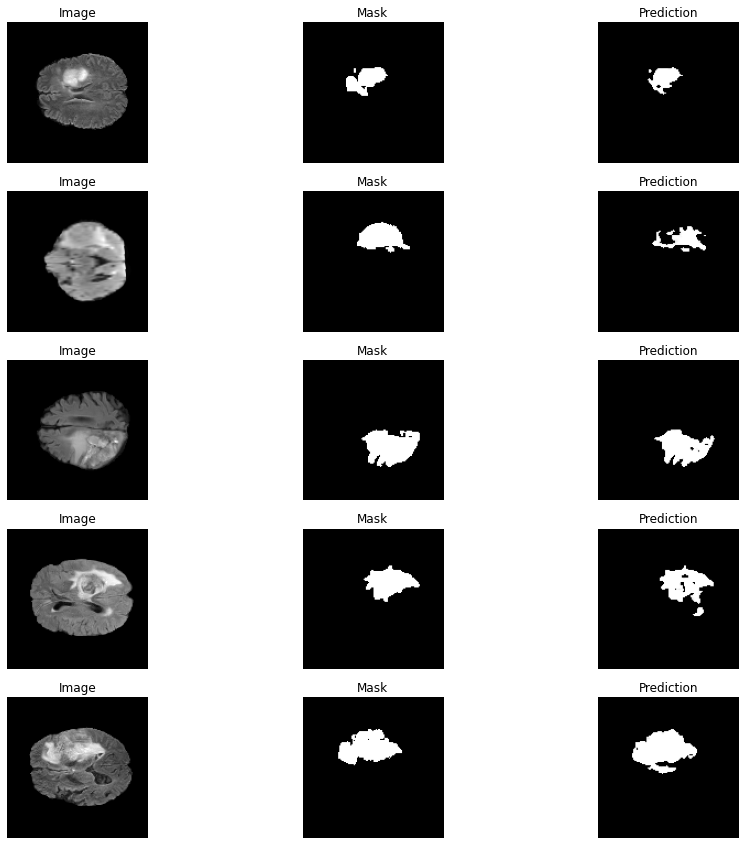

In [17]:
# sampling n_sample random images from the test set
n_sample = 5
sample = np.random.choice(len(test_images), n_sample, replace=False)

# plotting the results
fig, ax = plt.subplots(n_sample, 3, figsize=(15, 15))
for i, idx in enumerate(sample):
    ax[i, 0].imshow(test_images[idx].squeeze(), cmap='gray')
    ax[i, 1].imshow(test_masks[idx].squeeze(), cmap='gray')
    r = torch.sigmoid(model(test_images[idx].unsqueeze(0).to(device))).detach().cpu().squeeze()
    r[r < 0.9] = 0
    ax[i, 2].imshow(r, cmap='gray')
    ax[i, 0].set_title('Image')
    ax[i, 1].set_title('Mask')
    ax[i, 2].set_title('Prediction')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')